# STRMaps

You can view the map at https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/STRMap.html FOR NOW
File will remain at s3://filestogeaux.garyscorner.net/pub/STRMap.html  (requester pays use AWS CLI [--request-payer requester])

Datasets:
* (2023-07-17) https://data.nola.gov/Housing-Land-Use-and-Blight/Map-of-Short-Term-Rental-Licenses/j5u3-2ueh

In [1]:
import pandas as pd
import folium
import numpy as np
import folium.plugins

from datetime import datetime

In [2]:
! curl https://data.nola.gov/api/views/en36-xvxg/rows.csv?accessType=DOWNLOAD -o DataSets\Short-Term_Rental_Permit_Applications.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  383k    0  383k    0     0   171k      0 --:--:--  0:00:02 --:--:--  171k
100 9298k    0 9298k    0     0  2882k      0 --:--:--  0:00:03 --:--:-- 2882k
100 9298k    0 9298k    0     0  2881k      0 --:--:--  0:00:03 --:--:-- 2881k


In [3]:
strDf = pd.read_csv("./DataSets/Short-Term_Rental_Permit_Applications.csv")

In [4]:
#drop without location
strDf = strDf[ strDf['X'] > 0.0]

In [5]:
strDf.drop(columns=['X','Y'],inplace=True)

In [6]:
#drop dups and withdrawn
strDf = strDf[ ~(strDf['Current Status'].isin(['Duplicate','Withdrawn'])) ]

In [7]:
strDf['Link'] = strDf['Link'].map(lambda url:  f"<a target='_blank' href='{url}'>One Stop App</a>")

In [8]:
%%time

def getPoints(val):
    try:
        
        lat,lon = val[1:-1].split(', ')
        lon = float(lon)
        lat = float(lat)
        pt = (lat,lon)
        
    except Exception as e:
        print(val)
        raise(e)
        
    return pt

strDf['Location'] = strDf['Location'].map(getPoints)


Wall time: 50 ms


In [9]:
strDf['Address'] = strDf.apply(lambda a: f"<a target='_blank' href='http://maps.google.com/maps?q=&layer=c&cbll={a['Location'][0]},{a['Location'][1]}'>{a['Address']}</a>",axis=1)

In [10]:
strDf['Current Status'].value_counts()

Expired    14224
Denied      7428
Pending     4019
Issued      2355
Revoked      143
Name: Current Status, dtype: int64

In [11]:
statusList = list(np.unique(strDf['Current Status']))

In [12]:
%%time

def getPopStr(row):
    
    popStr = "<table>"
    for key in row.keys():
        val = row[key] if not pd.isna(row[key]) else ''
        
        popStr += "<tr style='border-bottom-width:1px'><td>%s</td> <td>%s</td></tr>" % (key,val)
        
    
    popStr += "</table>"
    
    return popStr


map = folium.Map(location=[29.99532,-89.99836], \
                 zoom_start=12)

for status in statusList:
    mask = strDf['Current Status'] == status
    markers = folium.plugins.MarkerCluster(locations=strDf['Location'][mask].to_list(), \
                                           popups=strDf[mask].apply(getPopStr, axis=1).to_list(), \
                                           name=status, \
                                           show=False, \
                                           chunkedLoading=True).add_to(map)

markers = folium.plugins.MarkerCluster(locations=strDf['Location'].to_list(), \
                                           popups=strDf.apply(getPopStr, axis=1).to_list(), \
                                           name='All', \
                                           show=True, \
                                           chunkedLoading=True).add_to(map)


folium.LayerControl().add_to(map)
pass

Wall time: 10.9 s


In [13]:
title_html = f'''
<div style="margin-left:25%;width:50%;float:left">
        <h3 align="center" style="font-size:16px"><b>Map of STR License Applications</b></h3>
        <h3 align="center" style="font-size:12px">(Including Issued/Expired/Denied/Pending/Revoked [use layers to select for currently issued])</h3>
</div>
<div style="float:right;width:25%;">
        <p align="right" style="font-size:10px">
            The purpose of this map is to provide contact information in case you have an issue with something near you!<br />
            <a href="https://github.com/GarysCorner/NewORleansSTR" target="_blank">GitHub Project and More Info</a><br />
             Dataset:  <a target="_blank" href="https://data.nola.gov/Housing-Land-Use-and-Blight/Map-of-Short-Term-Rental-Licenses/j5u3-2ueh">https://data.nola.gov/Housing-Land-Use-and-Blight/Map-of-Short-Term-Rental-Licenses/j5u3-2ueh</a><br />
             Last Update:  {datetime.now().strftime('%b %d %Y')}
        </p>
</div>
<div style="clear:both"></div>
             '''
#I just stold this from slashdot I usually dont do that but I need to add some context ASAP
map.get_root().html.add_child(folium.Element(title_html))

In [14]:
#you can uncomment that to see the map in this notebook but the notebook will balloon to 85 megs
#map

In [15]:
map.save('STRMap.html')

In [16]:
#https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/STRMap.html
!aws s3 cp STRMap.html s3://filestogeaux.garyscorner.net/pub/ --acl public-read

Completed 256.0 KiB/139.0 MiB (45.7 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/139.0 MiB (55.2 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/139.0 MiB (80.4 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/139.0 MiB (106.3 KiB/s) with 1 file(s) remaining 
Completed 1.2 MiB/139.0 MiB (116.5 KiB/s) with 1 file(s) remaining 
Completed 1.5 MiB/139.0 MiB (131.3 KiB/s) with 1 file(s) remaining 
Completed 1.8 MiB/139.0 MiB (144.7 KiB/s) with 1 file(s) remaining 
Completed 2.0 MiB/139.0 MiB (153.4 KiB/s) with 1 file(s) remaining 
Completed 2.2 MiB/139.0 MiB (171.4 KiB/s) with 1 file(s) remaining 
Completed 2.5 MiB/139.0 MiB (159.2 KiB/s) with 1 file(s) remaining 
Completed 2.8 MiB/139.0 MiB (165.3 KiB/s) with 1 file(s) remaining 
Completed 3.0 MiB/139.0 MiB (167.4 KiB/s) with 1 file(s) remaining 
Completed 3.2 MiB/139.0 MiB (171.9 KiB/s) with 1 file(s) remaining 
Completed 3.5 MiB/139.0 MiB (185.1 KiB/s) with 1 file(s) remaining 
Completed 3.8 MiB/139.0 MiB (189.4 KiB/s) with 1

In [17]:
!aws s3 cp s3://filestogeaux.garyscorner.net/pub/STRMap.html s3://requesterpays.garyscorner.net/datasets/html/

Completed 8.0 MiB/139.0 MiB (7.2 MiB/s) with 1 file(s) remaining
Completed 16.0 MiB/139.0 MiB (11.9 MiB/s) with 1 file(s) remaining
Completed 24.0 MiB/139.0 MiB (17.7 MiB/s) with 1 file(s) remaining
Completed 32.0 MiB/139.0 MiB (23.5 MiB/s) with 1 file(s) remaining
Completed 40.0 MiB/139.0 MiB (28.8 MiB/s) with 1 file(s) remaining
Completed 48.0 MiB/139.0 MiB (33.9 MiB/s) with 1 file(s) remaining
Completed 56.0 MiB/139.0 MiB (38.1 MiB/s) with 1 file(s) remaining
Completed 64.0 MiB/139.0 MiB (43.3 MiB/s) with 1 file(s) remaining
Completed 72.0 MiB/139.0 MiB (48.6 MiB/s) with 1 file(s) remaining
Completed 80.0 MiB/139.0 MiB (52.7 MiB/s) with 1 file(s) remaining
Completed 88.0 MiB/139.0 MiB (50.2 MiB/s) with 1 file(s) remaining
Completed 96.0 MiB/139.0 MiB (54.6 MiB/s) with 1 file(s) remaining
Completed 104.0 MiB/139.0 MiB (58.8 MiB/s) with 1 file(s) remaining
Completed 112.0 MiB/139.0 MiB (62.8 MiB/s) with 1 file(s) remaining
Completed 120.0 MiB/139.0 MiB (67.1 MiB/s) with 1 file(s) rema

In [18]:
print(f"Finished {datetime.now()}")

Finished 2023-07-21 11:11:01.515598


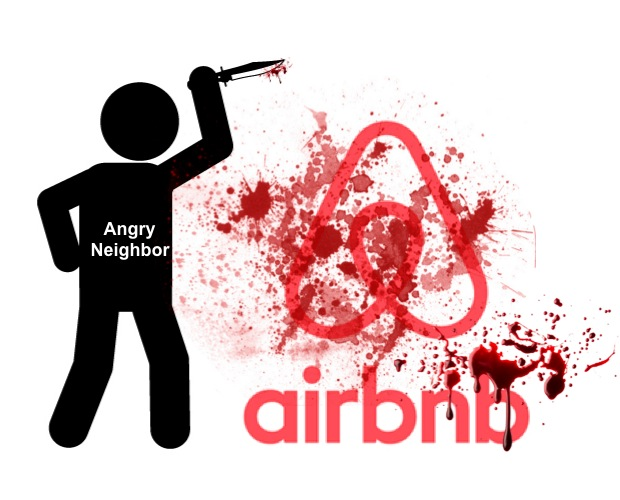